# 1. Setup and Libraries

### 1.1 Installing Libraries

In [1]:
!pip install openai-whisper ffmpeg jiwer -qU --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.3 MB/s eta 0:00:00


### 1.2 Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from IPython.display import display, Markdown, HTML, Audio
from tqdm.notebook import tqdm
import requests
from io import BytesIO
from urllib.request import urlopen
import librosa
import requests
import os
import gc
import psutil
import time
import json
import re

from jiwer import wer

import whisper

from kaggle_secrets import UserSecretsClient

### 1.3 Preparing Static and Environment Variables

In [3]:
user_secrets = UserSecretsClient()
# GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
# HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
BASE_URL = "/kaggle/input/audio-data/audio/audio"

BANKING_PATH = BASE_URL + '/audio_samples/banking/'
INSURANCE_PATH = BASE_URL + "/audio_samples/insurance"
RETAIL_PATH = BASE_URL + "/audio_samples/retail"
TELECOM_PATH = BASE_URL + "/audio_samples/telecom"

DOMAIN_MAP = {'telco': 'telecom'}

### 1.4 Helper Functions

In [4]:
def display_df(df: pd.DataFrame):
    html = df.head(300).to_html(index=False)

    scrollable = f'''
    <div style="
        max-height: 300px;
        max-width: 100%;
        overflow: auto;
        border: 1px solid #ccc;
        white-space: nowrap;
    ">
        {html}
    </div>
    '''

    display(HTML(scrollable))

In [5]:
def get_audio_and_path(df, idx, base_path):
    if 'AudioFile' not in df.columns:
        raise KeyError("DataFrame must contain 'AudioFile'")
    rel_path = df.at[idx, 'AudioFile']
    if base_path.startswith(('http://','https://')):
        full_path = f"{base_path.rstrip('/')}/{rel_path.lstrip('/')}"
        player = Audio(url=full_path)
    else:
        full_path = os.path.join(base_path, rel_path)
        player = Audio(filename=full_path)
    return player, full_path

In [6]:
def visualize_and_clear(model):
    """
    Measures CPU and GPU memory before and after deleting the model
    and clearing caches, then plots a bar chart.
    """
    process = psutil.Process()
    cpu_before = process.memory_info().rss / 1024**2
    gpu_before = torch.cuda.memory_allocated() / 1024**2 if torch.cuda.is_available() else 0

    # Move model to CPU (if applicable) and delete
    try:
        model.to("cpu")
    except Exception:
        pass
    del model
    torch.cuda.empty_cache()
    gc.collect()

    cpu_after = process.memory_info().rss / 1024**2
    gpu_after = torch.cuda.memory_allocated() / 1024**2 if torch.cuda.is_available() else 0

    labels = ["CPU", "GPU"]
    before = [cpu_before, gpu_before]
    after = [cpu_after, gpu_after]
    x = range(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar([i - width/2 for i in x], before, width, label="Before")
    ax.bar([i + width/2 for i in x], after, width, label="After")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Memory (MB)")
    ax.legend()
    plt.show()

In [7]:
def clean(t):
    # 1) strip tags + punctuation
    t = re.sub(r"\[.*?\]", "", t)
    t = re.sub(r"[^\w\s]", "", t)
    t = t.lower()
    # 2) drop filler/pronoun words
    t = re.sub(r"\b(po|ho|ah|um|eh|ko|mo)\b", "", t)
    # 3) collapse pag xxx → pagxxx
    t = re.sub(r"\bpag\s+(\w+)", r"pag\1", t)
    # 4) dedupe repeated words
    t = re.sub(r"\b(\w+)( \1)+\b", r"\1", t)
    # 5) normalize whitespace
    return re.sub(r"\s+", " ", t).strip()

In [8]:
def evaluate_whisper(df, model, overlap_thresh=0.8):
    records = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating"):
        dom  = DOMAIN_MAP.get(row['Domain'], row['Domain'])
        url  = f"{BASE_URL}/audio_samples/{dom}/{row['AudioFile']}"
        asr  = model.transcribe(url, language="tl", task="transcribe")["text"]
        trans = model.transcribe(url, task="translate")["text"]
        ref  = row['case_text']
        
        p = clean(asr)
        r = clean(ref)
        
        # perfect if substring
        if p in r or r in p:
            err = 0.0
        else:
            # or if token‐overlap ≥ threshold
            ptoks = set(p.split())
            rtoks = set(r.split())
            if ptoks and len(ptoks & rtoks) / len(ptoks) >= overlap_thresh:
                err = 0.0
            else:
                err = wer(r, p)
        
        records.append({
            "AudioFile":      url,
            "Actual":      ref,
            "Transcription":  asr,
            "Translation":    trans,
            "Cleaned Actual":      r,
            "Cleaned Transcription":  p,
            "WER":            err
        })
    
    result_df   = pd.DataFrame(records)
    overall_wer = result_df["WER"].mean()
    return result_df, overall_wer

# 2. Loading the Dataset

In [9]:
df = pd.read_csv('/kaggle/input/audio-data/synthetic_audio_bert.csv')
display_df(df)

case_id,case_text_value_type,case_text,case_source,case_type,case_transaction_type,case_status,case_priority_level,date_time_created,date_time_closed,customer_tier,RecordingId,SpeakerId,SegmentDuration,Domain,SampleRate,BitDepth,Role,IsNative,Age,Gender,Country,Accent,MainAudioFile,AudioFile
328659,Single message,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Phone,Deposits,Inquiry,New,Medium,2024-01-26T08:00:00+08:00,NaN,Mid,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:5.735,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328659.wav
328660,Single message,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:01:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:6.024,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328660.wav
328661,Single message,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:02:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:13.792,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328661.wav
328662,Single message,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,Phone,Deposits,Inquiry,New,Low,2024-01-26T08:03:00+08:00,NaN,High,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:3.162,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328662.wav
328663,Single message,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]",Phone,Deposits,Inquiry,New,Medium,2024-01-26T08:04:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:11.985,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328663.wav
328664,Single message,"Ang pangalan ko ay ""Doris Kelly""",Phone,Deposits,Request,New,High,2024-01-26T08:05:00+08:00,NaN,High,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:2.928,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328664.wav
328665,Single message,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Phone,Credit Cards,Inquiry,New,Low,2024-01-26T08:06:00+08:00,NaN,Low,12a95507-8727-497f-a599-a65d12c3ba42,6106C194-2F98-4C04-B0DC-666E2B3D10B9,00:00:5.617,banking,8000,16,customer,True,28,Female,Philippines,Cavite,Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328665.wav
328666,Single message,Maraming salamat ho [n_s/] Maaari niyo rin po bang pakiberipika sa akin ang petsa ng inyong kapanganakan,Phone,Deposits,Request,New,Low,2024-01-26T08:07:00+08:00,NaN,Mid,12a95507-8727-497f-a599-a65d12c3ba42,E1EBF390-D319-46CE-96D2-1CEBC0F7396C,00:00:5.752,banking,8000,16,agent,True,33,Female,Philippines,National Capital Region (Metro Manila),Audio/12a95507-8727-497f-a599-a65d12c3ba42.wav,sliced_audio/banking_328666.wav
328667,Single message,"Ang petsa ng aking kapanganakan ay [eng_start/] ""January"" twenty-seven nineteen eighty-six [eng_end/]",Ph

### 2.1 Truncating to Align with Gemini Tests

In [10]:
df = df
print(df.shape)

(779, 25)


### 2.2 Loading Sample Audio Data

In [11]:
audio_idx = 115

sample_audio, sample_audio_url = get_audio_and_path(df, audio_idx, BANKING_PATH)
print(sample_audio_url)
sample_audio

/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_330158.wav


# 3. OpenAI [Whisper](https://github.com/openai/whisper) Models
### Available Models and Languages

There are six Whisper model sizes—**tiny**, **base**, **small**, **medium**, **large**, and **turbo**—each offering a trade-off between speed and accuracy. Four sizes also provide English-only variants (noted `.en`) which generally improve performance for English transcription, particularly on smaller models. Relative inference speeds are measured on an NVIDIA A100 GPU transcribing English speech; your mileage may vary by language, speaking rate, and hardware.

| Size   | Parameters | English-only Model | Multilingual Model | Approx. VRAM | Relative Speed vs. Large |
|:------:|:----------:|:------------------:|:------------------:|:------------:|:------------------------:|
| tiny   | 39 M       | `tiny.en`          | `tiny`             | ~1 GB        | ~10×                     |
| base   | 74 M       | `base.en`          | `base`             | ~1 GB        | ~7×                      |
| small  | 244 M      | `small.en`         | `small`            | ~2 GB        | ~4×                      |
| medium | 769 M      | `medium.en`        | `medium`           | ~5 GB        | ~2×                      |
| large  | 1 550 M    | N/A                | `large`            | ~10 GB       | 1×                       |
| turbo  | 809 M      | N/A                | `turbo`            | ~6 GB        | ~8×                      |

The `.en` variants (e.g. **`tiny.en`**, **`base.en`**) yield better English transcription accuracy, with diminishing returns on **`small.en`** and **`medium.en`**. The **`turbo`** model is an optimized version of **`large-v3`**, offering almost **8×** speed at near-large accuracies.

See more [HERE](https://openai.com/index/whisper/).

### 3.1 Tiny Model

In [12]:
tiny_model = whisper.load_model("tiny")

100%|█████████████████████████████████████| 72.1M/72.1M [00:01<00:00, 71.3MiB/s]


In [13]:
tiny_transcribe = tiny_model.transcribe(
    sample_audio_url,
    language="tl",
    task="transcribe"
)

tiny_translate = tiny_model.transcribe(
    sample_audio_url,
    language="tl",
    task="translate"
)

In [14]:
# English translation
display(Markdown(f"**English translation:**  \n\n{tiny_translate['text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Actual Tagalog transcription
display(Markdown(f"**Actual Tagalog transcription:**  \n\n{df.loc[audio_idx, 'case_text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Whisper Tagalog transcription
display(Markdown(f"**Tagalog transcription:**  \n\n{tiny_transcribe['text']}"))

**English translation:**  

 Thank you, Director. I will continue to ensure the publicise of expression tolerance and prevention and our language.

**Actual Tagalog transcription:**  

Naiintindihan ko [eng_start/] ma'am [eng_end/] [filler/] Ayon po dito sa ating [eng_start/] system [eng_end/] [filler/] magbubukas po ang [eng_start/] branch [eng_end/] na iyan sa oras po ng alas-nueve ng umaga

**Tagalog transcription:**  

 Magd mum barkas-faan, session gen Sa-horasory na ang ala-Newén ina magga

In [15]:
tiny_df, tiny_eval = evaluate_whisper(df, tiny_model)
print("Tiny Model Average Word Error Rate (WER):\n", tiny_eval)

tiny_df.to_csv('tiny_df.csv', index=False)

display_df(tiny_df)

Evaluating:   0%|          | 0/779 [00:00<?, ?it/s]

Tiny Model Average Word Error Rate (WER):
 1.2009943526034552


AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",rong imishi lama sa p viktig ko moin ba 73 rng ng pastereng too ye,but even containers are being used so that each bottle contains their CATup contains themselves,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,rong imishi lama sa p viktig moin ba 73 rng ng pastereng too ye,0.941176
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sere-sita, a...zać-take nums kad unko n poi sa� puarang ali-kon ko pa� r Hetoshya kaぇon ko laha...","it does not serve pork meat, only bone as a wing or because that is enough",teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,seresita azaćtake nums kad unko n poi sa puarang alikon pa r hetoshya kaぇon laha,1.166667
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ugga rula kung pèreukan Well you know, yaw s tira by like a boil dyang, mkaramit, care kung empowering or ako may ay harsakaw bhagayos na bhagk child o updated naman kako akong siya ay niya пл logos.",I used to sing and sing back and forth but my 100%E congressers returned to milky school.,ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ugga rula kung pèreukan well you know yaw s tira by like a boil dyang mkaramit care kung empowering or ako may ay harsakaw bhagayos na bhagk child o updated naman kako akong siya ay niya пл logos,1.666667
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,haut numero ni matang ng akhan sa inyo ba ang ko,"Okay, let's go to the locker room.",oo meron naman na akong account sa inyong bangko,haut numero ni matang ng akhan sa inyo ba ang,1.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]",faktong meinigan mgahuba ay magaaya ng cuba machinery ayang boko niyantermalan so<|tl|>tak011 ko ay duh is fairness ma ran from memo Malan ykとか ay migrated in cubama k Indeed ang weropo anang ras maoolin,", for our attended meetings. To them, I'd like to remind them of the topics that were all the rest of our response.",ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,faktong meinigan mgahuba ay magaaya ng cuba machinery ayang boko niyantermalan sotltak011 ay duh is fairness ma ran from memo malan ykとか ay migrated in cubama k indeed ang weropo anang ras maoolin,1.523810
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",ang tangalad ko ay Doris Kelly,as well.,ang pangalan ay doris kelly,ang tangalad ay doris kelly,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",ang nomiron na Akhin National Insurance i13245698,"I'm the first international insurance I won 3, 2, 4, 5, 6, 9, 8.",ang numero ng aking national insurance ay one three two 

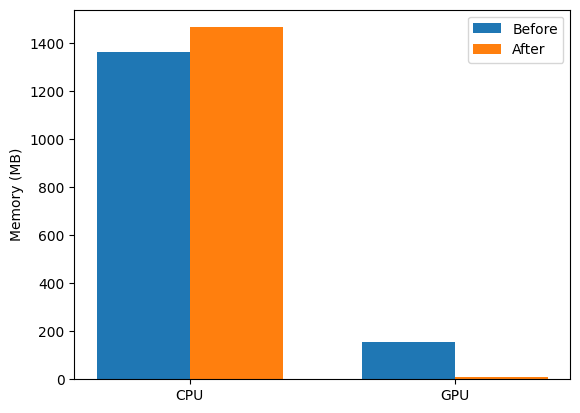

In [16]:
visualize_and_clear(tiny_model)

### 3.2 Base Model

In [17]:
base_model = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 63.1MiB/s]


In [18]:
base_transcribe = base_model.transcribe(
    sample_audio_url,
    language="tl",
    task="transcribe"
)

base_translate = base_model.transcribe(
    sample_audio_url,
    language="tl",
    task="translate"
)

In [19]:
# English translation
display(Markdown(f"**English translation:**  \n\n{base_translate['text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Actual Tagalog transcription
display(Markdown(f"**Actual Tagalog transcription:**  \n\n{df.loc[audio_idx, 'case_text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Whisper Tagalog transcription
display(Markdown(f"**Tagalog transcription:**  \n\n{base_transcribe['text']}"))

**English translation:**  

 I still have that behind me. I am now here in our frame, thirsty roots are from the odors paid by the new demon called names.

**Actual Tagalog transcription:**  

Naiintindihan ko [eng_start/] ma'am [eng_end/] [filler/] Ayon po dito sa ating [eng_start/] system [eng_end/] [filler/] magbubukas po ang [eng_start/] branch [eng_end/] na iyan sa oras po ng alas-nueve ng umaga

**Tagalog transcription:**  

 na inting dian ko mga. Ayon po dito sa ating system magbubo kaspo ang branch na iyan sa oras po ng alas nueve ng umaga.

In [20]:
base_df, base_eval = evaluate_whisper(df, base_model)
print("Base Model Average Word Error Rate (WER):\n", base_eval)

base_df.to_csv('base_df.csv', index=False)

display_df(base_df)

Evaluating:   0%|          | 0/779 [00:00<?, ?it/s]

Base Model Average Word Error Rate (WER):
 0.8813320567067845


AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Kh炼Mig markers ng pagwest term ay nagt scientific,My treating was more womanwide. It looked better attached and tied coordinates. This way we CH expresed out.,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,kh炼mig markers ng pagwest term ay nagt scientific,0.941176
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sarasita, may tanong lang ako, tungkol sa perang nalikong ko para sa kaong gawa.",I'm just going to recite it. I'll just recite it. I'll just recite it.,teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,sarasita may tanong lang ako tungkol sa perang nalikong para sa kaong gawa,0.333333
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ayaman uba signal, at<|tl|>",I'm going to talk to my friends and my parents. I'm going to talk to my parents. I'm not going to talk to my parents. I'm going to talk to my parents.,ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ayaman uba signal attl,1.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,A'o meron na mana ako ako'ng sa inyong bang ko.,"Oh, but if there's still a lot I can just just control it by writing a book on a golden page source",oo meron naman na akong account sa inyong bangko,ao meron na mana ako akong sa inyong bang,0.666667
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]","Pagang hubat, ay ay kubama hindi ang baunin ang tangalan. Ang tangalan ko ay Doris Kelly, maran, salamatoma, ay kudinkubama hindi ang nonggirapon ang rakan ng insurance.","and I am really curious about the plans for today speed integrator my wishes are Doris, Kelly say thank you my good fortune to you and Mmmurrom and I will thank Balono for",ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,pagang hubat ay kubama hindi ang baunin ang tangalan ang tangalan ay doris kelly maran salamatoma ay kudinkubama hindi ang nonggirapon ang rakan ng insurance,1.047619
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",ang pangalan ko ay Doris Kelly.,I saved my sweet part from Scalte's Collection. Okay...,ang pangalan ay doris kelly,ang pangalan ay doris kelly,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]","Ang nomilong na akim National Insurance, ay 13245698.","I will now move on to the national insurance. I want 3, 2, 4, 5, 6, 9, 8.",ang numero ng aking national insurance ay one three two four five six nine eight,ang nomilong na akim national insurance ay 13245698,0.733333
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328666.wav,Maraming salamat ho [n_s/] Maaari niyo rin po b

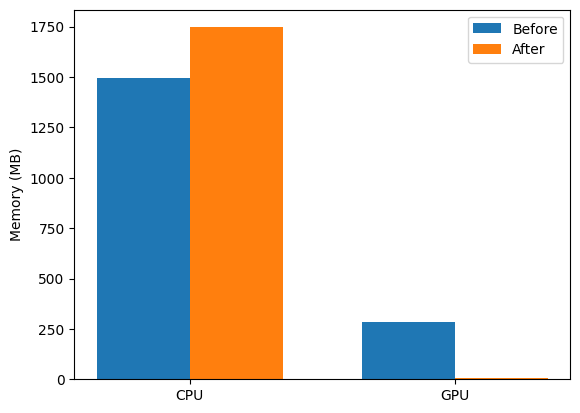

In [21]:
visualize_and_clear(base_model)

### 3.3 Small Model

In [22]:
small_model = whisper.load_model("small")

100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 119MiB/s]


In [23]:
small_transcribe = small_model.transcribe(
    sample_audio_url,
    language="tl",
    task="transcribe"
)

small_translate = small_model.transcribe(
    sample_audio_url,
    language="tl",
    task="translate"
)

In [24]:
# English translation
display(Markdown(f"**English translation:**  \n\n{small_translate['text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Actual Tagalog transcription
display(Markdown(f"**Actual Tagalog transcription:**  \n\n{df.loc[audio_idx, 'case_text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Whisper Tagalog transcription
display(Markdown(f"**Tagalog transcription:**  \n\n{small_transcribe['text']}"))

**English translation:**  

 I understand, ma'am. This is our system. I will open the branch at 9 a.m.

**Actual Tagalog transcription:**  

Naiintindihan ko [eng_start/] ma'am [eng_end/] [filler/] Ayon po dito sa ating [eng_start/] system [eng_end/] [filler/] magbubukas po ang [eng_start/] branch [eng_end/] na iyan sa oras po ng alas-nueve ng umaga

**Tagalog transcription:**  

 Nga, entindiyan ko mam. Ayong po dito sa ating system, magbubokas po ang branch na iyan sa oras po ng alas 9 na umaga.

In [25]:
small_df, small_eval = evaluate_whisper(df, small_model)
print("Small Model Average Word Error Rate (WER):\n", small_eval)

small_df.to_csv('small_df.csv', index=False)

display_df(small_df)

Evaluating:   0%|          | 0/779 [00:00<?, ?it/s]

Small Model Average Word Error Rate (WER):
 0.6341354970251801


AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Pero nami salamat sa pagtawag sa bakon ang makati ako po si Tensita. Ano kung pwede mo ito nukasiyo?,"Thank you for calling me, my friends, and I, Tensita. What can you do about this?",maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,pero nami salamat sa pagtawag sa bakon ang makati ako si tensita ano kung pwede ito nukasiyo,0.588235
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sa reseita, may tanong lang ako tungkol sa perang naligom ko para sa kawang gawa.",I have a question about my money for the kawang gawa.,teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,sa reseita may tanong lang ako tungkol sa perang naligom para sa kawang gawa,0.416667
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ang gano ba? Sige, sasubuhan ko po kayong tuluan, po ko dyan. Maraming, marikupo ba ma, at tanong mo na kung may account tapo ba kayo sa banko? O, meron na ma na akong account sa inyong banko.","Oh, so you're the one who's going to help me. Do I have a lot of questions? Do you have an account on your bank? Yes, I do have an account on your bank.",ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ang gano ba sige sasubuhan kayong tuluan dyan maraming marikupo ba ma at tanong na kung may account tapo ba kayo sa banko o meron na ma na akong account sa inyong banko,1.142857
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,"Oo, meron naman ako ng account sa inyong banko.","Yes, I have an account on your bank.",oo meron naman na akong account sa inyong bangko,oo meron naman ako ng account sa inyong banko,0.333333
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]","Agan, Huwbat. May aliku ko ba mahi ni ang buonin ang pangalan? Ang pangalan ko ay Doris Kelly Maran. Salamat ho. May aliku din ko ba mahi ni ang ngumira po ng Graphene Insurance.",How are you? Can I ask you to name the whole name? My name is Doris Kelly Maran. Thank you. Can I also ask you to name the number of the National Insurance?,ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,agan huwbat may aliku ba mahi ni ang buonin ang pangalan ang pangalan ay doris kelly maran salamat may aliku din ba mahi ni ang ngumira ng graphene insurance,1.047619
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",Ang pangalan ko ay Dory Skelly,My name is Doris Kelly,ang pangalan ay doris kelly,ang pangalan ay dory skelly,0.400000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Ang numero na aking national insurance ay 132-45698.,The number of my national insurance is 132-45698.,ang numero ng aking national insurance

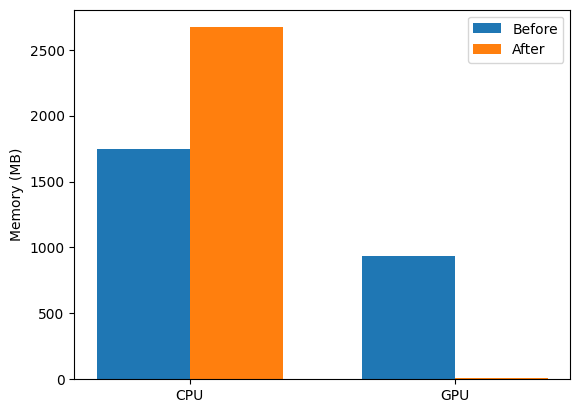

In [26]:
visualize_and_clear(small_model)

### 3.4 Medium Model

In [27]:
medium_model = whisper.load_model("medium")

100%|█████████████████████████████████████| 1.42G/1.42G [00:20<00:00, 75.3MiB/s]


In [28]:
medium_transcribe = medium_model.transcribe(
    sample_audio_url,
    language="tl",
    task="transcribe"
)

medium_translate = medium_model.transcribe(
    sample_audio_url,
    language="tl",
    task="translate"
)

In [29]:
# English translation
display(Markdown(f"**English translation:**  \n\n{medium_translate['text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Actual Tagalog transcription
display(Markdown(f"**Actual Tagalog transcription:**  \n\n{df.loc[audio_idx, 'case_text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Whisper Tagalog transcription
display(Markdown(f"**Tagalog transcription:**  \n\n{medium_transcribe['text']}"))

**English translation:**  

 I understand ma'am. According to our system, that branch will open at 9 a.m.

**Actual Tagalog transcription:**  

Naiintindihan ko [eng_start/] ma'am [eng_end/] [filler/] Ayon po dito sa ating [eng_start/] system [eng_end/] [filler/] magbubukas po ang [eng_start/] branch [eng_end/] na iyan sa oras po ng alas-nueve ng umaga

**Tagalog transcription:**  

 Naintingdian ko ma'am. Ayaw po dito sa ating system, magbubukas po ang brunch na iyan sa oras po ng alas 9 ng umaga.

In [30]:
medium_df, medium_eval = evaluate_whisper(df, medium_model)
print("Medium Model Average Word Error Rate (WER):\n", medium_eval)

medium_df.to_csv('medium_df.csv', index=False)

display_df(medium_df)

Evaluating:   0%|          | 0/779 [00:00<?, ?it/s]

Medium Model Average Word Error Rate (WER):
 0.429881224762636


AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Marami salamat sa pagtaawag sa banko ng mga ati. Ako po si Tercita. Ano kung pwedeng ma-itunog ka sa inyo?,Thank you for calling the Bank of the Philippines. I am Tercita. What can I do for you?,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,marami salamat sa pagtaawag sa banko ng mga ati ako si tercita ano kung pwedeng maitunog ka sa inyo,0.529412
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sa recita, may tanong lang ako tungkol sa perang nalikom ko para sa kawanggawa.",I have a question about the money I spent for the construction.,teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,sa recita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ah gano'n mo ba? Sinyo, susubukan ko po kayong tulungan, toko dyan. Marami... mahali ko po bang ma-tanong muna kung may account ka po kayo sa banko? Oo, meron naman na akong account sa inyong banko.","Oh, is that so? I'll try to help you with that. Can I ask if you have an account in the bank? Yes, I have an account in your bank.",ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ganon ba sinyo susubukan kayong tulungan toko dyan marami mahali bang matanong muna kung may account ka kayo sa banko oo meron naman na akong account sa inyong banko,0.714286
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,"Oo, meron naman akong account sa inyong bank ko.","Yes, I already have an account in your bank.",oo meron naman na akong account sa inyong bangko,oo meron naman akong account sa inyong bank,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]",Pagan ko ba? Maaari ko bang mahi ni ang buunin niyang pangalan? Ang pangalan ko ay Doris Kelly. Marami salamat ho. Maaari ko rin ko bang mahi ni ang numero po ng National Insurance?,Is it possible for me to ask for your full name? My name is Doris Kelly. Thank you very much. Is it also possible for me to ask for your number of National Insurance?,ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,pagan ba maaari bang mahi ni ang buunin niyang pangalan ang pangalan ay doris kelly marami salamat maaari rin bang mahi ni ang numero ng national insurance,0.666667
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",Ang pangalan ko ay Doris Kelly.,My name is Doris Kelly.,ang pangalan ay doris kelly,ang pangalan ay doris kelly,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Ang numero na aking national insurance ay 13245698.,My national insurance number is 13245698.,ang numero ng aking natio

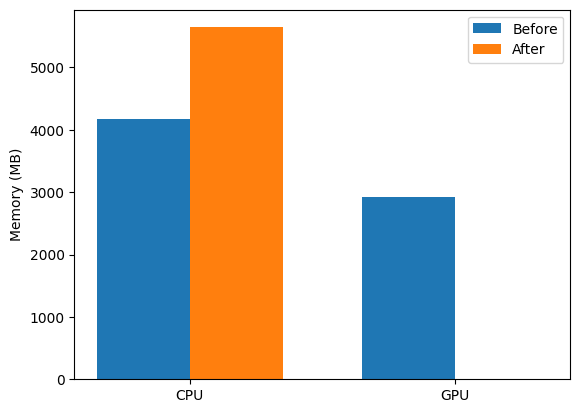

In [31]:
visualize_and_clear(medium_model)

### 3.5 Large Model

In [32]:
large_model = whisper.load_model("large")

100%|██████████████████████████████████████| 2.88G/2.88G [00:23<00:00, 134MiB/s]


In [33]:
large_transcribe = large_model.transcribe(
    sample_audio_url,
    language="tl",
    task="transcribe"
)

large_translate = large_model.transcribe(
    sample_audio_url,
    language="tl",
    task="translate"
)

In [34]:
# English translation
display(Markdown(f"**English translation:**  \n\n{large_translate['text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Actual Tagalog transcription
display(Markdown(f"**Actual Tagalog transcription:**  \n\n{df.loc[audio_idx, 'case_text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Whisper Tagalog transcription
display(Markdown(f"**Tagalog transcription:**  \n\n{large_transcribe['text']}"))

**English translation:**  

 I understand, ma'am. According to our system, the branch will be opened at 9 in the morning.

**Actual Tagalog transcription:**  

Naiintindihan ko [eng_start/] ma'am [eng_end/] [filler/] Ayon po dito sa ating [eng_start/] system [eng_end/] [filler/] magbubukas po ang [eng_start/] branch [eng_end/] na iyan sa oras po ng alas-nueve ng umaga

**Tagalog transcription:**  

 Naintindihan ko, ma'am. Ayon po dito sa ating system, magbubukas po ang branch na iyan sa oras po ng alas 9 ng umaga.

In [35]:
large_df, large_eval = evaluate_whisper(df, large_model)
print("Large Model Average Word Error Rate (WER):\n", large_eval)

large_df.to_csv('large_df.csv', index=False)

display_df(large_df)

Evaluating:   0%|          | 0/779 [00:00<?, ?it/s]

Large Model Average Word Error Rate (WER):
 0.3033211307046216


AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Maraming salamat sa pagtawag sa Bako ng Makati. Ako po si Teresita. Ano pong pwede may tuno pa sa inyo?,Thank you very much for calling Banko na Makati. I am Teresita. What can I ask you?,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,maraming salamat sa pagtawag sa bako ng makati ako si teresita ano pong pwede may tuno pa sa inyo,0.294118
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sa resita, may tanong lang ako tungkol sa perang nalikom ko para sa kawang gawa.",I have a question regarding the money I borrowed for the construction work.,teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,sa resita may tanong lang ako tungkol sa perang nalikom para sa kawang gawa,0.333333
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ah, ganun mo ba? Sige, sasubukan ko po kayong tulungan tungkol dyan. Maraming, maraming ko po bang matatanong muna kung may account po ba kayo sa banko? Oo, meron naman na akong account sa inyong banko.","I will try to help you with that. Can I ask if you have an account in your bank? Yes, I have an account in your bank.",ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ganun ba sige sasubukan kayong tulungan tungkol dyan maraming bang matatanong muna kung may account ba kayo sa banko oo meron naman na akong account sa inyong banko,0.714286
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,"Oo, meron naman na akong account sa inyong banko.","Yes, I already have an account in your bank.",oo meron naman na akong account sa inyong bangko,oo meron naman na akong account sa inyong banko,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]","Ah, ganun po ba? Maaari ko po bang mahini ang buong inyong pangalan? Ang pangalan ko ay Doris Kelly. Maraming salamat po. Maaari ko rin po bang mahini ang numero po ng National Insurance?",Is that so? May I ask for your full name? My name is Doris Kelly. Thank you very much. May I also ask for your National Insurance number?,ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,ganun ba maaari bang mahini ang buong inyong pangalan ang pangalan ay doris kelly maraming salamat maaari rin bang mahini ang numero ng national insurance,0.476190
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",Ang pangalan ko ay Doris Kelly.,My name is Doris Kelly.,ang pangalan ay doris kelly,ang pangalan ay doris kelly,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eight [eng_end/]",Ang numero ng aking national insurance ay 132-45698.,The number of my National Insurance is 132-45698.,ang numero ng aking national insurance

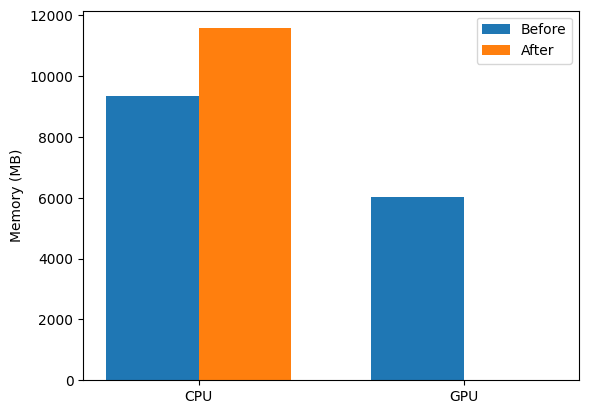

In [36]:
visualize_and_clear(large_model)

### 3.6 Turbo Model

In [37]:
turbo_model = whisper.load_model("turbo")

100%|█████████████████████████████████████| 1.51G/1.51G [00:16<00:00, 96.5MiB/s]


In [38]:
turbo_transcribe = turbo_model.transcribe(
    sample_audio_url,
    language="tl",
    task="transcribe"
)

turbo_translate = turbo_model.transcribe(
    sample_audio_url,
    language="tl",
    task="translate"
)

In [39]:
# English translation
display(Markdown(f"**English translation:**  \n\n{turbo_translate['text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Actual Tagalog transcription
display(Markdown(f"**Actual Tagalog transcription:**  \n\n{df.loc[audio_idx, 'case_text']}"))
display(HTML("<hr style='margin:8px 0'>"))

# Whisper Tagalog transcription
display(Markdown(f"**Tagalog transcription:**  \n\n{turbo_transcribe['text']}"))

**English translation:**  

 Naintindihan ko, Ma'am. Ayon po dito sa ating system, magbubukas po ang brunch na iyan sa oras po ng alas 9 ng umaga.

**Actual Tagalog transcription:**  

Naiintindihan ko [eng_start/] ma'am [eng_end/] [filler/] Ayon po dito sa ating [eng_start/] system [eng_end/] [filler/] magbubukas po ang [eng_start/] branch [eng_end/] na iyan sa oras po ng alas-nueve ng umaga

**Tagalog transcription:**  

 Naintindihan ko ma'am. Ayon po dito sa ating system, magbubukas po ang brunch na iyan sa oras po ng alas 9 ng umaga.

In [40]:
turbo_df, turbo_eval = evaluate_whisper(df, turbo_model)
print("Turbo Model Average Word Error Rate (WER):\n", turbo_eval)

turbo_df.to_csv('turbo_df.csv', index=False)

display_df(turbo_df)

Evaluating:   0%|          | 0/779 [00:00<?, ?it/s]

Turbo Model Average Word Error Rate (WER):
 0.33198060499053694


AudioFile,Actual,Transcription,Translation,Cleaned Actual,Cleaned Transcription,WER
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328659.wav,"Maraming salamat sa pag tawag sa ""Bangko ng Makati"" ako po si ""Teresita"" ano pong pwedeng maitulong ko sa inyo",Maraming salamat sa pagtawag sa Banko na Makati. Ako po si Teresita. Ano pong pwedeng maitunok sa inyo?,Maraming salamat sa pagtawag sa Banko ng Makati. Ako po si Teresita. Ano pong pwedeng maitunok sa inyo?,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,maraming salamat sa pagtawag sa banko na makati ako si teresita ano pong pwedeng maitunok sa inyo,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328660.wav,Teresita [filler/] may tanong lang ako tungkol sa perang nalikom ko para sa kawang-gawa,"Sa Resita, may tanong lang ako tungkol sa perang nalikom ko para sa kawang gawa.","Sa Resita, may tanong lang ako tungkol sa perang nalikom ko para sa kawang gawa.",teresita may tanong lang ako tungkol sa perang nalikom para sa kawanggawa,sa resita may tanong lang ako tungkol sa perang nalikom para sa kawang gawa,0.333333
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328661.wav,[filler/] Ganun ho ba sige ho [filler/] susubukan ko po kayong tulungan tungkol dyan [filler/] marami [filler/] maaari ko po bang ma-tanong muna kung may [eng_start/] account [eng_end/] na po ba kayo sa bangko,"Ay, ganun ba? Sige, susubukan ko po kayong tulungan tungkol dyan. Maraming maraming po bang matatanong mo na kung may account po ba kayo sa banko? Oo, meron naman na akong account sa inyong banko.","A, gano ba? Sige, ah, susubukan ko po kayong tulungan tungkol dyan. Ah, marami, ah, marami ko po bang maatanong mo na kung may account po ba kayo sa banko? Oo, meron naman na akong account sa inyong banko.",ganun ba sige susubukan kayong tulungan tungkol dyan marami maaari bang matanong muna kung may account na ba kayo sa bangko,ay ganun ba sige susubukan kayong tulungan tungkol dyan maraming bang matatanong na kung may account ba kayo sa banko oo meron naman na akong account sa inyong banko,0.761905
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328662.wav,Oo meron naman na akong [eng_start/] account [eng_end/] sa inyong bangko,"Oo, meron naman na akong account sa inyong bangko.","Oo, meron naman na akong account sa inyong bangko.",oo meron naman na akong account sa inyong bangko,oo meron naman na akong account sa inyong bangko,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328663.wav,"[filler/] Ganun ho ba pe- maaari ko po bang mahingi ang buo ninyong pangalan maraming salamat ho maaari ko rin po bang mahingi ang numero po ng [eng_start/] ""National Insurance"" [eng_end/]","Ah, ganun po ba? Maaari ko po bang mahini ang buunin ng pangalan? Ang pangalan ko ay Doris Kelly. Marami salamat. Maaari ko rin po bang mahini ang numero po ng National Insurance?","A, ganun po ba? Maaari ko po bang mahini ang buunin ng pangalan? Ang pangalan ko ay Doris Kelly. Marami salamat. Maaari ko rin po bang mahini ang numero po ng National Insurance?",ganun ba pe maaari bang mahingi ang buo ninyong pangalan maraming salamat maaari rin bang mahingi ang numero ng national insurance,ganun ba maaari bang mahini ang buunin ng pangalan ang pangalan ay doris kelly marami salamat maaari rin bang mahini ang numero ng national insurance,0.523810
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328664.wav,"Ang pangalan ko ay ""Doris Kelly""",Ang pangalan ko ay Doris Kelly.,Ang pangalan ko ay Doris Kelly.,ang pangalan ay doris kelly,ang pangalan ay doris kelly,0.000000
/kaggle/input/audio-data/audio/audio/audio_samples/banking/sliced_audio/banking_328665.wav,"Ang numero ng aking [eng_start/] ""National Insurance"" [eng_end/] ay [eng_start/] one three two four five six nine eig

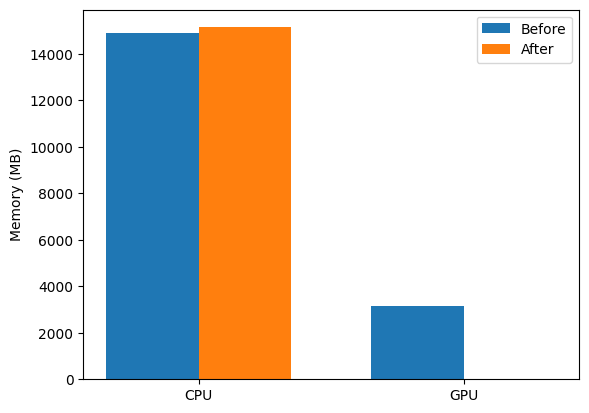

In [41]:
visualize_and_clear(turbo_model)

# 4. Analysis and Insights

### 4.1 Word Error Rate Comparisons

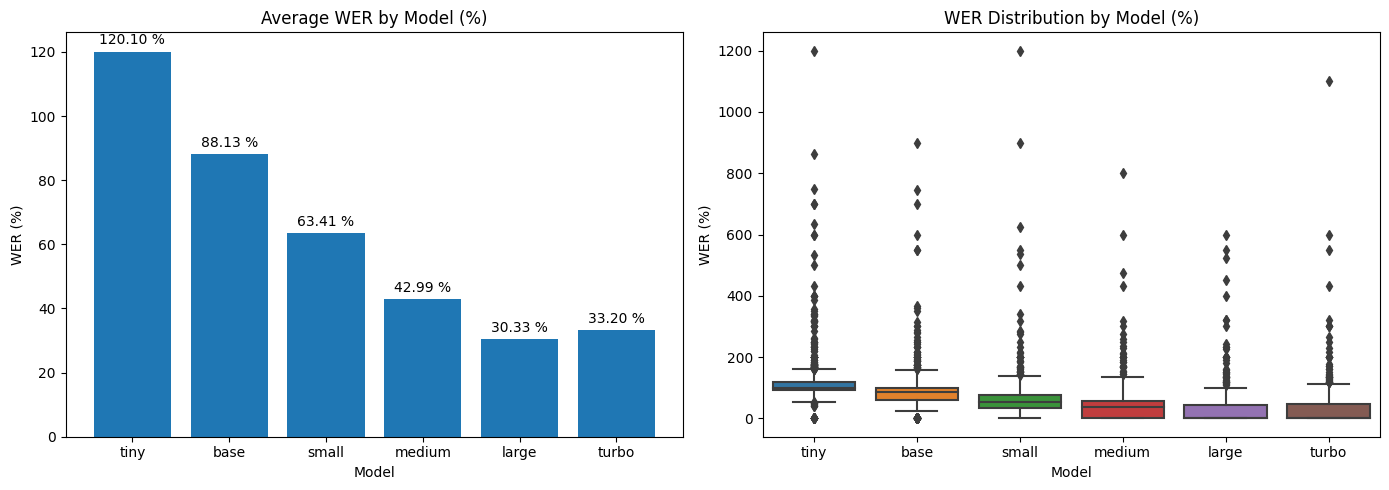

In [42]:
models = ['tiny', 'base', 'small', 'medium', 'large', 'turbo']
wers = [tiny_eval, base_eval, small_eval, medium_eval, large_eval, turbo_eval]
wers_pct = [w * 100 for w in wers]

# build long DataFrame for box-plot
all_wers = pd.concat([
    pd.DataFrame({
        'model': m,
        'wer_pct': df['WER'] * 100
    })
    for m, df in zip(models, [tiny_df, base_df, small_df, medium_df, large_df, turbo_df])
], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Bar chart
bars = axes[0].bar(models, wers_pct)
axes[0].set_title("Average WER by Model (%)")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("WER (%)")

# annotate bars manually
for bar in bars:
    h = bar.get_height()
    axes[0].annotate(
        f"{h:.2f} %",
        xy=(bar.get_x() + bar.get_width() / 2, h),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# (b) Box-plot
sns.boxplot(
    x='model',
    y='wer_pct',
    data=all_wers,
    order=models,
    ax=axes[1]
)
axes[1].set_title("WER Distribution by Model (%)")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("WER (%)")

plt.tight_layout()
plt.show()

### 4.2 Sample Text Comparisons

In [43]:
def display_text_comparisons_split(sample_idxs, dfs, models):
    """
    Display two styled tables:
    1. Transcription comparison only
    2. Translation comparison only

    Args:
        sample_idxs: list of row indices to display
        dfs: list of DataFrames [tiny_df, base_df, ...]
        models: list of model names corresponding to dfs
    """
    # Build columns for transcriptions
    trans_cols = pd.MultiIndex.from_tuples(
        [("Reference", "")] + [(m, "Transcription") for m in models]
    )
    # Build columns for translations
    transl_cols = pd.MultiIndex.from_tuples(
        [("Reference", "")] + [(m, "Translation") for m in models]
    )

    # Prepare data rows
    trans_data = []
    transl_data = []
    for idx in sample_idxs:
        # Reference uses "Cleaned Actual"
        ref = dfs[0].loc[idx, "Cleaned Actual"]
        trans_row = [ref] + [df.loc[idx, "Cleaned Transcription"] for df in dfs]
        transl_row = [ref] + [df.loc[idx, "Translation"] for df in dfs]
        trans_data.append(trans_row)
        transl_data.append(transl_row)

    trans_df = pd.DataFrame(trans_data, index=[f"Sample {i}" for i in sample_idxs], columns=trans_cols)
    transl_df = pd.DataFrame(transl_data, index=[f"Sample {i}" for i in sample_idxs], columns=transl_cols)

    # Common styling
    table_style = [
        {"selector": "th",     "props": [("font-family", "monospace"),
                                         ("background-color", "#333"),
                                         ("color", "white"),
                                         ("padding", "8px")]},
        {"selector": "td",     "props": [("font-family", "monospace"),
                                         ("padding", "8px"),
                                         ("color", "#222") ]},
        {"selector": "tbody tr:nth-child(odd)", "props": [("background-color", "#f9f9f9")]},
        {"selector": "tbody tr:nth-child(even)","props": [("background-color", "white")]},
    ]

    # Display transcription table
    trans_styled = (trans_df.style
        .set_table_styles(table_style)
        .set_properties(**{"white-space": "pre-wrap", "text-align": "left"})
        .set_caption("Transcription Comparison Across Models"))
    display(trans_styled)

    # Display translation table
    transl_styled = (transl_df.style
        .set_table_styles(table_style)
        .set_properties(**{"white-space": "pre-wrap", "text-align": "left"})
        .set_caption("Translation Comparison Across Models"))
    display(transl_styled)

In [44]:
models = ['tiny', 'base', 'small', 'medium', 'large', 'turbo']
dfs = [tiny_df, base_df, small_df, medium_df, large_df, turbo_df]
sample_idxs = [0, 10, 42, 60, 65]
display_text_comparisons_split(sample_idxs, dfs, models)

,Reference,tiny,base,small,medium,large,turbo
,,Transcription,Transcription,Transcription,Transcription,Transcription,Transcription
Sample 0,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,rong imishi lama sa p viktig moin ba 73 rng ng pastereng too ye,kh炼mig markers ng pagwest term ay nagt scientific,pero nami salamat sa pagtawag sa bakon ang makati ako si tensita ano kung pwede ito nukasiyo,marami salamat sa pagtaawag sa banko ng mga ati ako si tercita ano kung pwedeng maitunog ka sa inyo,maraming salamat sa pagtawag sa bako ng makati ako si teresita ano pong pwede may tuno pa sa inyo,maraming salamat sa pagtawag sa banko na makati ako si teresita ano pong pwedeng maitunok sa inyo
Sample 10,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account nang walang anumang problema,masa ako si ng maraming para ang dunid ng ong charitiran ita tanong lang sana ng maari bang ilagayon sa bank account ng o lang anomong problema,masadu kasi maraming pera ang donate ng ong charitiran ita tanong lang sana kung maarikobang ilagayon sa bank account ng walang ano mag problema,masado kasing maraming pera ang donate ng charity ryan itatanong lang sana kung maari bang ilagayon sa bank account ng walang anong problema,masyado kasing maraming pera ang donate noong charity run itatanong lang sana kung maari bang ilagay yan sa bank account na walang anumang problema,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account nang walang anumang problema,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account ng walang anumang problema
Sample 42,naintindihan pwede na ra min tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email,aa na ingting bill закongan a padinaramin poto tayang pomyli sa is bethibilang ngaklasinang inija aumentartltltllan ang ipamong pine gong a ujiminas ay beid vastanno temps,a na ikaw niyan a pa tinaramin tayo pwemili sa ibat ibang klasin ng nija pa direm na gumamit ay ng email,pwede na ramin tayong pamily sa isbat ibaang klasin ng nija pwede rin na gumamit tayo ng email,naintindihan pwede naramin tayong pumili sa ibath ibang klase ng ninja pwede rin na gumamit tayo ng email,naintindihan pwede na rin tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email,naintindihan pwede na namin tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email
Sample 60,sandali pwede bang ulitin yung huli mong sinabi,tan kalayor padebu u crit il kayon yung williamung stina,tanalay pay di bang ulitin yung hulimong sinabi,tandali pwede ba ang ulitin yung hulimong sinabi,pwede bang ulitin ang huli mong sinabi,sandali pwede bang ulitin yung huli mong sinabi,tandali pwede bang ulitin yung huli mong sinabi
Sample 65,ayun salamat sa inyong oras meron pa kayong opo meron pa ba akong maitutulong sa inyo,fata awal kwim あ maama for akayong na maa paepund ba ako may jungle longtl sa enabled,ayunivat at siyalam badanu ang kon different,ayun salamat sa inong oran meron pa paok ayong meron pa akong may tutulong sa inyo,ayun salamat sa inyong oras meron pa kayong apo meron pa ba ako may tutulong sa inyong,ayan salamat sa inyong oras meron pa kayong meron pa ba akong may tutulong sa inyo,ayun salamat sa inyong oras meron pa kayong meron pa ba akong may tutulong sa inyo


,Reference,tiny,base,small,medium,large,turbo
,,Translation,Translation,Translation,Translation,Translation,Translation
Sample 0,maraming salamat sa pagtawag sa bangko ng makati ako si teresita ano pong pwedeng maitulong sa inyo,but even containers are being used so that each bottle contains their CATup contains themselves,My treating was more womanwide. It looked better attached and tied coordinates. This way we CH expresed out.,"Thank you for calling me, my friends, and I, Tensita. What can you do about this?",Thank you for calling the Bank of the Philippines. I am Tercita. What can I do for you?,Thank you very much for calling Banko na Makati. I am Teresita. What can I ask you?,Maraming salamat sa pagtawag sa Banko ng Makati. Ako po si Teresita. Ano pong pwedeng maitunok sa inyo?
Sample 10,masyado kasing maraming pera ang nadonate noong charity run itatanong lang sana kung maaari bang ilagay yun sa bank account nang walang anumang problema,the serpent just makes it different for her life she said her husband helped her to change her feelings and that she can only use her…,There are FREE IPP's down to date. I've come hope to meet people on the banks account for insecure problems in need.,The charity is too much. I just wonder if I can put that in the bank account without any problem.,Charity Run donated a lot of money. I will ask if I can put it in the bank account without any problem.,Charity Run has donated a lot of money. I would just like to ask if I can put it in the bank account without any problem.,Masyado kasing maraming pera ang na-donate noong Charity Run. Itatanong ko lang sana kung maaari ko bang ilagay yun sa bank account nang walang anumang problema.
Sample 42,naintindihan pwede na ra min tayong pumili sa ibat ibang klase ng media pwede rin na gumamit tayo ng email,"They were scriptures that state of immigration in the mashing system operating later before the process is seriously motioning,","For all of you, I think this is what this should look like. Could I change the example in whether she'll leave the Mexico幫 right? Where would the e-mail be, though.",I understand. We can choose from different classes of NIDA. We can also use email.,I understand. We can also buy from other kinds of media. We can also use email.,I understand. We can also choose from different types of media. We can also use email.,Pwede na namin po tayong pumili sa iba't ibang klase ng media. Pwede rin po na gumamit tayo ng email.
Sample 60,sandali pwede bang ulitin yung huli mong sinabi,maybe trim them up in the family,Take out the dark purple hibernation.,Can you repeat what you said?,Wait. Can you repeat the last thing you said?,Wait. Can you repeat what you said?,"Tandali, pwede bang ulitin mo yung huli mong sinabi?"
Sample 65,ayun salamat sa inyong oras meron pa kayong opo meron pa ba akong maitutulong sa inyo,"and this is why after that, I don't care who there is in Japan tomorrow, or they have to leave behind for a while because of you.","be immersive. I hope you got healed and you got another reason, that's why I will be crying sometimes drinking it.",Thank you for your time. Thank you. Do you have a friend who can help you?,Thank you for your time. Do you have any other questions?,Thank you for your time. Do I have anyone else who can help you?,Ayan po. Salamat po sa inyong oras. Meron po po kayong... Meron po po ba akong may tutulong sa inyo?
